In [1]:
# Import libraries 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import KFold, cross_val_score, train_test_split 
from sklearn.metrics import mean_squared_error 
from sklearn.decomposition import PCA 

In [4]:
#location of dataset  
url = "./Data/Hitters.csv" 
#read in data 
data = pd.read_csv(url).dropna() # to simply the analysis, we drop all missing values 
data

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


In [5]:
# create dummies variables 
dummies_variables = pd.get_dummies(data[['League', 'Division', 'NewLeague']])  
# create features and target 
target = data['Salary'] 
feature_to_drop = data.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64') 
X = pd.concat([feature_to_drop, dummies_variables[['League_N', 'Division_W', 'NewLeague_N']]], axis=1) 
#scaled data - preprocessing 
X_scaled = scale(X) 
# train test split 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, target, test_size=0.2, random_state=42) 

In [6]:
# First generate all the principal components 
pca = PCA() 
X_pc_train = pca.fit_transform(X_train) 
X_pc_train.shape 

(210, 19)

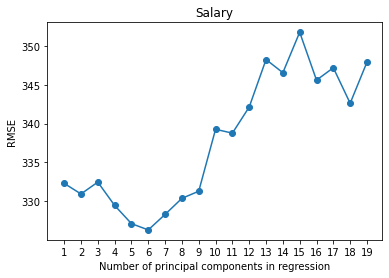

In [8]:
# Determining the best number of PCs to be used 
# The next step is to perform a 10-fold cross validation multiple linear regression 
# and choose the best number of PC to use by using RMSE (root mean squared error). 
 
# Define cross-validation folds 
cv = KFold(n_splits=10, shuffle=True, random_state=42) 
model = LinearRegression() 
rmse_score = [] 
# Calculate MSE score - based on 19 PCs 
for i in range(1, X_pc_train.shape[1]+1): 
    rmse = -cross_val_score(model, X_pc_train[:,:i], y_train, cv=cv, scoring='neg_root_mean_squared_error').mean() 
    rmse_score.append(rmse) 
# Plot results     
plt.plot(rmse_score, '-o') 
plt.xlabel('Number of principal components in regression') 
plt.ylabel('RMSE') 
plt.title('Salary') 
plt.xlim(xmin=-1) 
plt.xticks(np.arange(X_pc_train.shape[1]), np.arange(1, X_pc_train.shape[1]+1)) 
plt.show() 

#the best number of PC is 6 corresponding the lowest cross validation RMSE.  

In [9]:
# Train regression model on training data  
model = LinearRegression() 
model.fit(X_pc_train[:,:6], y_train) 
 
pcr_score_train = -cross_val_score(model, X_pc_train[:,:6], y_train, cv=cv,scoring='neg_root_mean_squared_error').mean() 
 
# Prediction with test data 
X_pc_test = pca.fit_transform(X_test)[:,:6] 
pred = model.predict(X_pc_test) 
pcr_score_test = mean_squared_error(y_test, pred, squared=False) 